<a href="https://colab.research.google.com/github/ariffinsarhid/Predicting-Airline-On-Time-Performance-In-Progress-/blob/main/Model_on_year_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore')
import io

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

In [8]:
url_1 = 'https://raw.githubusercontent.com/ariffinsarhid/Predicting-Airline-On-Time-Performance-In-Progress-/main/Data/final_table.csv'

df = pd.read_csv(url_1, index_col='flightdate')
df = df.drop(columns= 'Unnamed: 0')

In [9]:
df = pd.get_dummies(df, columns = ['airline', 'origincity', 'destcity'])

In [10]:
df_2020 = df[(df['year'] == 2020)]
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9287 entries, 26/02/20 to 25/03/20
Columns: 721 entries, year to destcity_Yuma
dtypes: float64(4), int64(14), uint8(703)
memory usage: 7.6+ MB


In [11]:
x1 = df_2020.drop(['arrdel15'],axis= 1)
y1 = df_2020.arrdel15

#train test split
x_train, x_test, y_train, y_test = train_test_split(x1, y1, stratify=y1, random_state = 42)


print(x_train.shape, y_train.shape)

(6965, 720) (6965,)


In [12]:
y1.value_counts()

0.0    8051
1.0    1236
Name: arrdel15, dtype: int64

In [13]:
y1.shape

(9287,)

In [14]:
def score(model,x_train, x_test):
    
    """
    This function scores the model by returning the confusion matrix and classification report of the model
    
    """
    
    # Get predictions
    preds = model.predict(x_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Flight Not Delay','Flight Delay']).plot(cmap='GnBu')

    print("Training Score:",model.score(x_train,y_train))
    print("Testing Score:",model.score(x_test,y_test))
    print("\n")
    print(classification_report(y_test, preds)) 


In [15]:
def roc(model, model_name, X_train, X_test): 
    
    """
    This function generates the ROC/AUC curve of the model.
    
    Due to the imbalanced nature of the data, the preferred metrics for this project is ROC/AUC.
    
    """      
    
    plt.figure(figsize=(16,10))
    
    # Predict probabilities from X_test
    df = pd.DataFrame(model.predict_proba(X_test))
    preds = df.drop(columns=0)
    
    # 
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)

    df2 = pd.DataFrame(model.predict_proba(X_train))
    preds2 = df2.drop(columns=0)
    fpr2, tpr2, _ = roc_curve(y_train, preds2)
    auc2 = roc_auc_score(y_train, preds2)
    
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,color='orange',label="%s test, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(fpr2,tpr2,color='blue',label="%s train, auc=%s" %(model_name, format(auc2,".3f")))
        plt.plot(y_test,y_test,color='gray',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    
    sns.despine(left=True,bottom=True)

In [16]:
preprocess_pipe = make_pipeline(MinMaxScaler())

In [17]:
#create pipeline
lr_pipe = make_pipeline(SMOTE(random_state = 42), 
                        LogisticRegression(max_iter=200, random_state = 42)
                       )
    

# define grid params for logistic regression
lr_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}
    

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr = GridSearchCV(lr_pipe, param_grid = lr_params, verbose = 1, n_jobs=-1, cv=3, scoring='roc_auc')

In [18]:
x_train_t = preprocess_pipe.fit_transform(x_train)
x_test_t = preprocess_pipe.transform(x_test)

In [19]:
grid_lr.fit(x_train_t,y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'saga',
       

In [20]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 0.7683761092050809
best params {'logisticregression__C': 0.1, 'logisticregression__class_weight': None, 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


Training Score: 0.8387613792975307
Testing Score: 0.7910362578514735


              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87      2013
         1.0       0.34      0.61      0.44       309

    accuracy                           0.79      2322
   macro avg       0.64      0.72      0.65      2322
weighted avg       0.85      0.79      0.81      2322



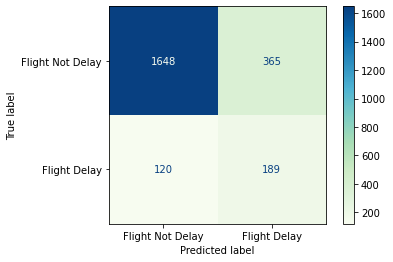

In [21]:
score(grid_lr, x_train_t, x_test_t)

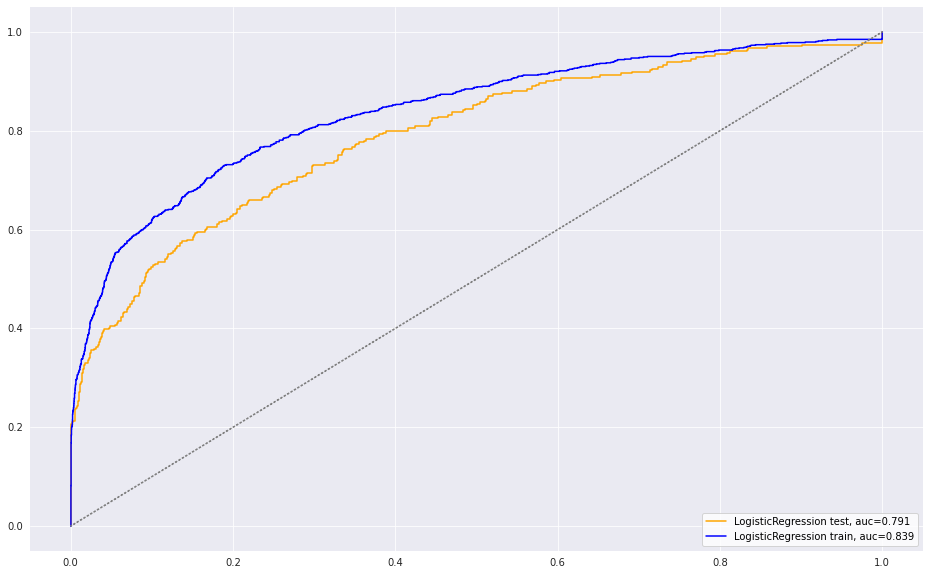

In [22]:
roc(grid_lr,"LogisticRegression", x_train_t, x_test_t)

In [23]:
##random forest

In [24]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

rf_pipe = make_pipeline(SMOTE(random_state=42),
                           
                           ### Insert Model here for future modelling ###
                           
                           RandomForestClassifier(random_state=42),
                          )

# define grid params for random forest classifier
rf_params = {
    'randomforestclassifier__n_estimators':[20,50,100],
    'randomforestclassifier__max_depth':[5,20,50],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__max_leaf_nodes':[5,10,15],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_rf = GridSearchCV(rf_pipe, param_grid = rf_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [25]:
grid_rf.fit(x_train_t,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [5, 20, 50],
                         'randomforestclassifier__max_leaf_nodes': [5, 10, 15],
                         'randomforestclassifier__n_estimators': [20, 50, 100]},
             scoring='roc_auc', verbose=1)

In [26]:
print("best score", grid_rf.best_score_)
print("best params", grid_rf.best_params_)

best score 0.6110548786159937
best params {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_leaf_nodes': 15, 'randomforestclassifier__n_estimators': 50}


Training Score: 0.6580651737128356
Testing Score: 0.623744206348058


              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79      2013
         1.0       0.20      0.47      0.28       309

    accuracy                           0.67      2322
   macro avg       0.55      0.59      0.53      2322
weighted avg       0.80      0.67      0.72      2322



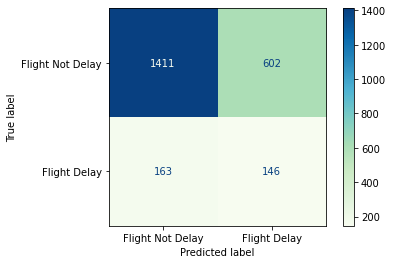

In [27]:
score(grid_rf, x_train_t, x_test_t)

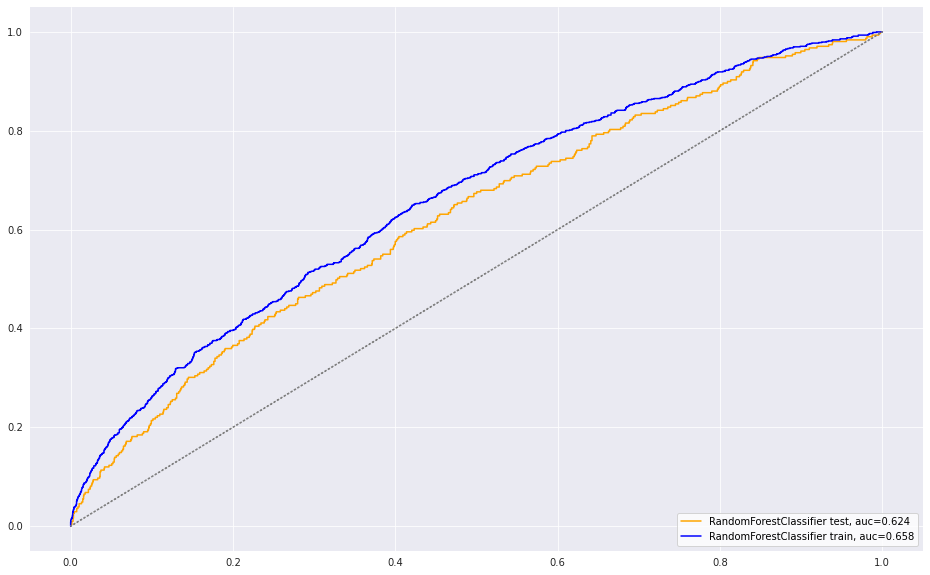

In [28]:
roc(grid_rf,"RandomForestClassifier", x_train_t, x_test_t)

In [29]:
## Gradient Boost

In [31]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

gb_pipe = make_pipeline(SMOTE(random_state=42),
                           
                           ### Insert Model here for future modelling ###
                           
                           GradientBoostingClassifier(random_state=42,
                                                      n_iter_no_change=3)
                          )


# define grid params for gradient boosting
gb_params = {
    'gradientboostingclassifier__learning_rate': [0.1, 0.2, 0.3],
    'gradientboostingclassifier__criterion' : ['friedman_mse','mse'],
    'gradientboostingclassifier__n_estimators': [20,50,100],
    'gradientboostingclassifier__max_features':['sqrt','log2'],
    'gradientboostingclassifier__loss':['deviance','exponential']
}

        
# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_gb = GridSearchCV(gb_pipe, param_grid = gb_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [33]:
grid_gb.fit(x_train_t,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(n_iter_no_change=3,
                                                                   random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'mse'],
                         'gradientboostingclassifier__learning_rate': [0.1, 0.2,
                                                                       0.3],
                         'gradientboostingclassifier__loss': ['deviance',
                                                              'exponential'],
                         'gradientboostingclassifier__max_features': ['sqrt',
                                                                      'log2'],
             

In [34]:
print("best score", grid_gb.best_score_)
print("best params", grid_gb.best_params_)

best score 0.6264671859671564
best params {'gradientboostingclassifier__criterion': 'friedman_mse', 'gradientboostingclassifier__learning_rate': 0.3, 'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__n_estimators': 100}


Training Score: 0.7548469545449835
Testing Score: 0.6505577821828021


              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88      2013
         1.0       0.27      0.33      0.30       309

    accuracy                           0.79      2322
   macro avg       0.58      0.60      0.59      2322
weighted avg       0.81      0.79      0.80      2322



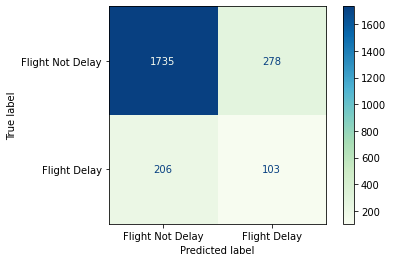

In [36]:
score(grid_gb, x_train_t, x_test_t)

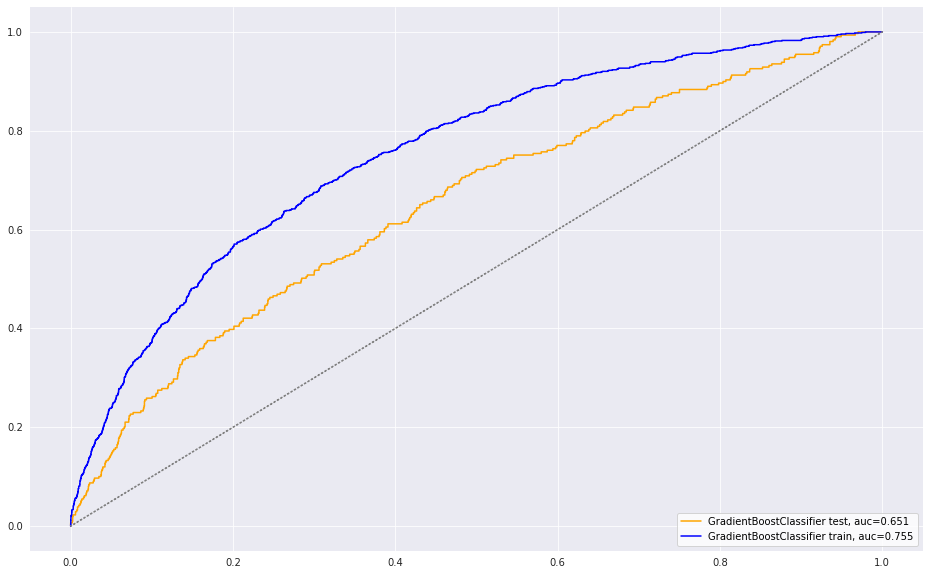

In [38]:
roc(grid_gb,"GradientBoostClassifier", x_train_t, x_test_t)